# hookの使い方(pytorch)
畳み込みニューラルネットワーク(CNN)のタスクでよくやり方が分からなくて困るのが、中間層へのアクセスである。[grad CAM](https://arxiv.org/abs/1610.02391)とかはこの情報が必須になる。全結合層の手前の畳み込み層の出力や勾配を見ようとすると、一番シンプルなのは、モデルをコピーして切り離してきて前段後段にわけることだ。まず前段だけ使ってモデルの中間出力を見る→その出力を後段に渡して、backwardで勾配を取りに行くというやり方もあるんだが、とんでもなくめんどくさい。もう少しスマートな方法として、pytorchが提供している、`nn.Module`に対して入出力、勾配の情報へのアクセスや演算をできるようにする`register_forward_hook`がある。

`register_forward_hook`は名前の通りforwardのときに機能する。backwardのときに機能するものもあるにはあるのだが、[ちょっと問題](https://github.com/pytorch/pytorch/issues/61519)があるらしい。詳しくはわからないのだが、`nn.Module`の`register_backward_hook`は使わずに、一工夫して、`register_forward_hook`だけで勾配の情報を取ることが推奨されているようだ。

ひとまず、どうやって実際つかうのか、動かしてみていきたいと思うが、`nn.Module`に対してのhookに入る前に、基本的な`Tensor`型に対するhookというものを見ていきたい。

## Tensorへのhook
そもそもhookって何に使うのかというと、`Tensor`の勾配にアクセスしてその値を変えたりできるようにする仕組みである。例えばめちゃ単純な例を考えてみる。

In [1]:
import torch
x=torch.tensor(4.0,requires_grad=True)
y=torch.tensor(2.0,requires_grad=True)
sum=x*x+2*y
sum.retain_grad()

double=x.register_hook(lambda grad:grad*2)
sum.backward()

`double=x.register_hook(lambda grad:grad*2)`が何をしているかと言うと、`x`に対して、勾配が２倍になる(`grad*2`)ようなhookを適応しました、ということになっている。無名関数で書いているが、後述するように関数で定義することもできる。勾配が２倍になっているかどうか確認してみよう。

In [2]:
x.grad, y.grad

(tensor(16.), tensor(2.))

x側の勾配は、通常の計算で期待される値(2x=8)の２倍になっている。
別の例に試すために初期化しておく

In [3]:
#先の計算でたまった勾配があったらわかりにくいので０にしている
if hasattr(x.grad,'grad'):x.grad.zero_()
if hasattr(y.grad,'grad'):y.grad.zero_()
#xにつけていたhookも外す
double.remove()

無名関数じゃなくて関数を使う例を書いておく。関数は引数一つで、その引数に対する演算結果を戻り値にする形で書く。

In [4]:
def hook(grad):
    return grad+100

sum=x*x+2*y
sum.retain_grad()

plus=y.register_hook(hook)
sum.backward()

In [5]:
x.grad, y.grad

(tensor(8.), tensor(102.))

どちらかと言うと、その計算結果を外側に取り出してあれこれしたいというケースが多いだろう。その場合には、クラスを定義して、クラス変数に結果を取り出すようの配列を定義して、クラスメソッドに上記のhook用の関数を定義して、それを`register_hook`に渡すというパターンを取ることが多い。
その例も見てみよう。

In [6]:
#先の計算でたまった勾配があったらわかりにくいので０にしている
if hasattr(x.grad,'grad'):x.grad.zero_()
if hasattr(y.grad,'grad'):y.grad.zero_()
#yにつけていたhookも外す
plus.remove()

In [7]:
class Saveoutput_tensor:
    def __init__(self):
        #結果の保存用の配列
        self.output=[]
        #hookを保持するための変数
        self.handle=None
    
    def save(self,target):
        #勾配に100加える
        def _hook(grad):
            self.output.append(grad+100)
        #上の操作をtargetとして指定したtensorに対して登録する
        self.handle=target.register_hook(_hook)

    #解除できるようにクラスメソッドを定義しておく
    def release(self):
        self.handle.remove()

sum=x*x+2*y
sum.retain_grad()

save=Saveoutput_tensor()
save.save(y)
sum.backward()

これは、結果を保存するための配列や、勾配に対する操作をクラス(`SaveOutput`)にまとめておき、そのインスタンスを作り、勾配を処理したいtensorを引数にして`save`というクラスメソッドを呼ぶことで、クラスの中のoutputに以下のように結果が貯められる。

In [8]:
save.output

[tensor(102.)]

## CNNの中間層の取得

hookは`Tensor`だけでなく、`nn.Module`にも設定できる。この場合、Tensorと変わるのは、hookの関数の引数が`(model, input, output)`の3つ組になることだ。たいていの場合はoutput自体や、outputの勾配を取得しに行くことになる。実例を見たほうが早いだろう。

例としていつものMNISTデータセットに対するシンプルなCNNでの分類問題を考えてみる。

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor(),
                                ])
mnist_train = \
    torchvision.datasets.MNIST(root='./',
                                      download=True,
                                      train=True,
                                      transform=transform)
mnist_test = \
    torchvision.datasets.MNIST(root='./',
                                      download=True,
                                      train=False,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=1,
                              shuffle=False)

100%|████████████████████████████| 9912422/9912422 [00:05<00:00, 1703999.76it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 49302276.69it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 1735742.24it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 8120429.99it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.nelements=7*7*32
        self.device = device
        self.conv1=nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,32,kernel_size=3,padding=1)
        self.l1 = nn.Linear(self.nelements, 10)

    def forward(self, x):
        h = self.conv1(x)
        h = torch.relu(h)
        h =F.max_pool2d(h,2)
        h=self.conv2(h)
        h=torch.relu(h)
        h=F.max_pool2d(h,2)
        h=h.view(-1,self.nelements)
        y = self.l1(h)   

        return y 

とりあえず学習

In [11]:
# モデルの設定
model = Net().to(device)
# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# 最適化関数の設定
optimizer = optimizers.Adam(model.parameters())
epochs = 20

for epoch in range(epochs):
    train_loss = 0.
    
    for (x, label) in train_dataloader:
        x = x.to(device)
        label=label.to(device)
        model.train()
    
        preds = model(x)
        loss = criterion(preds, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))


Epoch: 1, Loss: 0.256
Epoch: 2, Loss: 0.072
Epoch: 3, Loss: 0.053
Epoch: 4, Loss: 0.042
Epoch: 5, Loss: 0.036
Epoch: 6, Loss: 0.031
Epoch: 7, Loss: 0.027
Epoch: 8, Loss: 0.023
Epoch: 9, Loss: 0.021
Epoch: 10, Loss: 0.018
Epoch: 11, Loss: 0.016
Epoch: 12, Loss: 0.013
Epoch: 13, Loss: 0.013
Epoch: 14, Loss: 0.012
Epoch: 15, Loss: 0.011
Epoch: 16, Loss: 0.008
Epoch: 17, Loss: 0.008
Epoch: 18, Loss: 0.007
Epoch: 19, Loss: 0.007
Epoch: 20, Loss: 0.007


どんなものか見てみる

In [12]:
model.eval()
from tqdm import tqdm
with torch.no_grad():
    total=0.0
    correct=0.0
    for (x, label) in tqdm(test_dataloader):
        x=x.to(device)
        label=label.to(device)
        outputs=model(x)
        _, predicted=torch.max(outputs, dim=1)
        correct += int((predicted==label).sum())
        total += label.shape[0]

    print(' Validation Acc', correct/total)

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2123.70it/s]

 Validation Acc 0.9884


大体98％位出るだろう

念の為モデルを保存

In [13]:
torch.save(model.state_dict(), "model_MNIST_CNN.pth")

畳み込み2層目にアクセスしたい。

In [14]:
class SaveOutput:
    def __init__(self,model, target_layer):
        self.model=model
        self.layer_output=[]
        self.layer_grad=[]
        #特徴マップと勾配を取るためのhookを設定
        self.feature_handle=target_layer.register_forward_hook(self.feature)
        self.grad_handle=target_layer.register_forward_hook(self.gradient)
    
    def feature(self,model, input, output):
        activation=output
        self.layer_output.append(activation.to('cpu').detach())
    
    def gradient(self,model,input,output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # 勾配が無いとき用
            return
        #forward hookでも勾配が取れるようにするための工夫
        def _hook(grad):
            self.layer_grad.append(grad.to('cpu').detach())
        
        output.register_hook(_hook)
    
    def release(self):
        self.feature_handle.remove()
        self.grad_handle.remove()

モデルとアクセスしたい層の名称を渡す

In [15]:
save=SaveOutput(model,model.conv2)

モデルにデータを流し込んで、情報を取得する

In [16]:
img,label=next(iter(test_dataloader))
output=model(img.to(device))

このforwardでまず畳み込み二層目の出力が保存される

In [17]:
save.layer_output[0].shape

torch.Size([1, 32, 14, 14])

可視化してみる

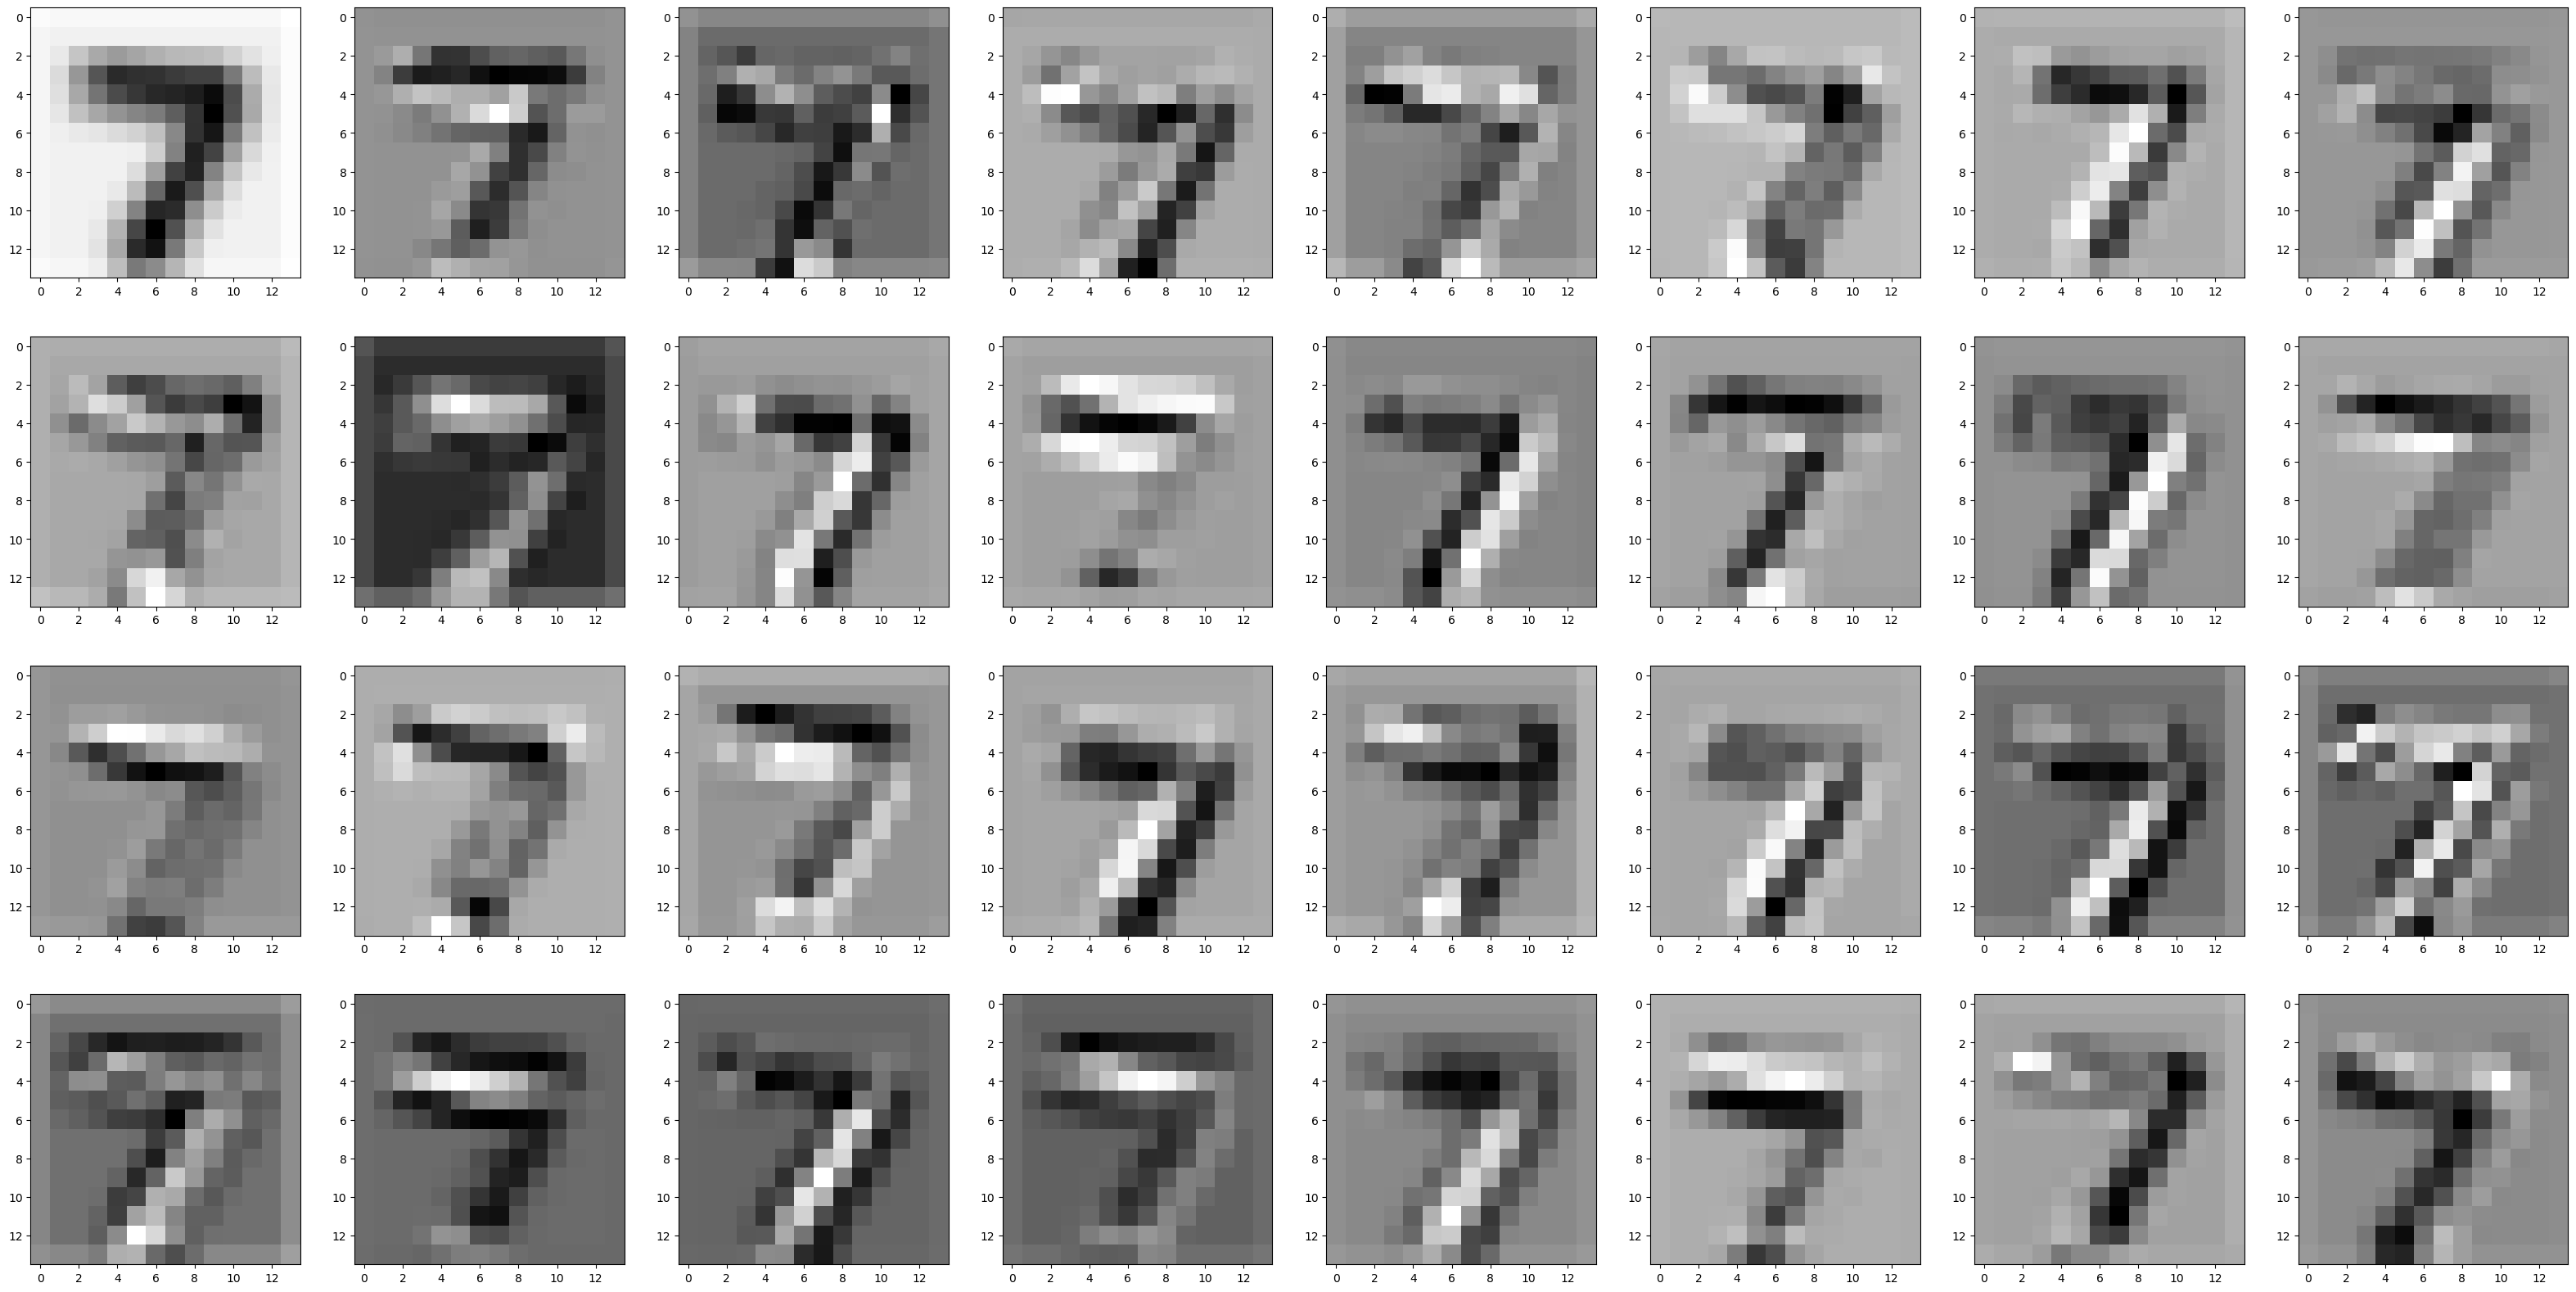

In [18]:
intermediate=save.layer_output[0].squeeze(0).numpy()
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(40,20))
for i,im in enumerate(intermediate):
    ax1=fig.add_subplot(4,8,i+1)
    ax1.imshow(im,'gray')

勾配を計算させる。そのために、分類結果をargmaxで決めて、その出力に対応する全結合層の出力要素に対して、backwardをかける。
（backwardはスカラーにしか使えない。今の場合分類問題なので、最大の値を返したもの→該当クラスとみなして、その勾配を取りに行く）

In [19]:
idx=torch.argmax(output)
output[0,idx].backward()

これも可視化しよう

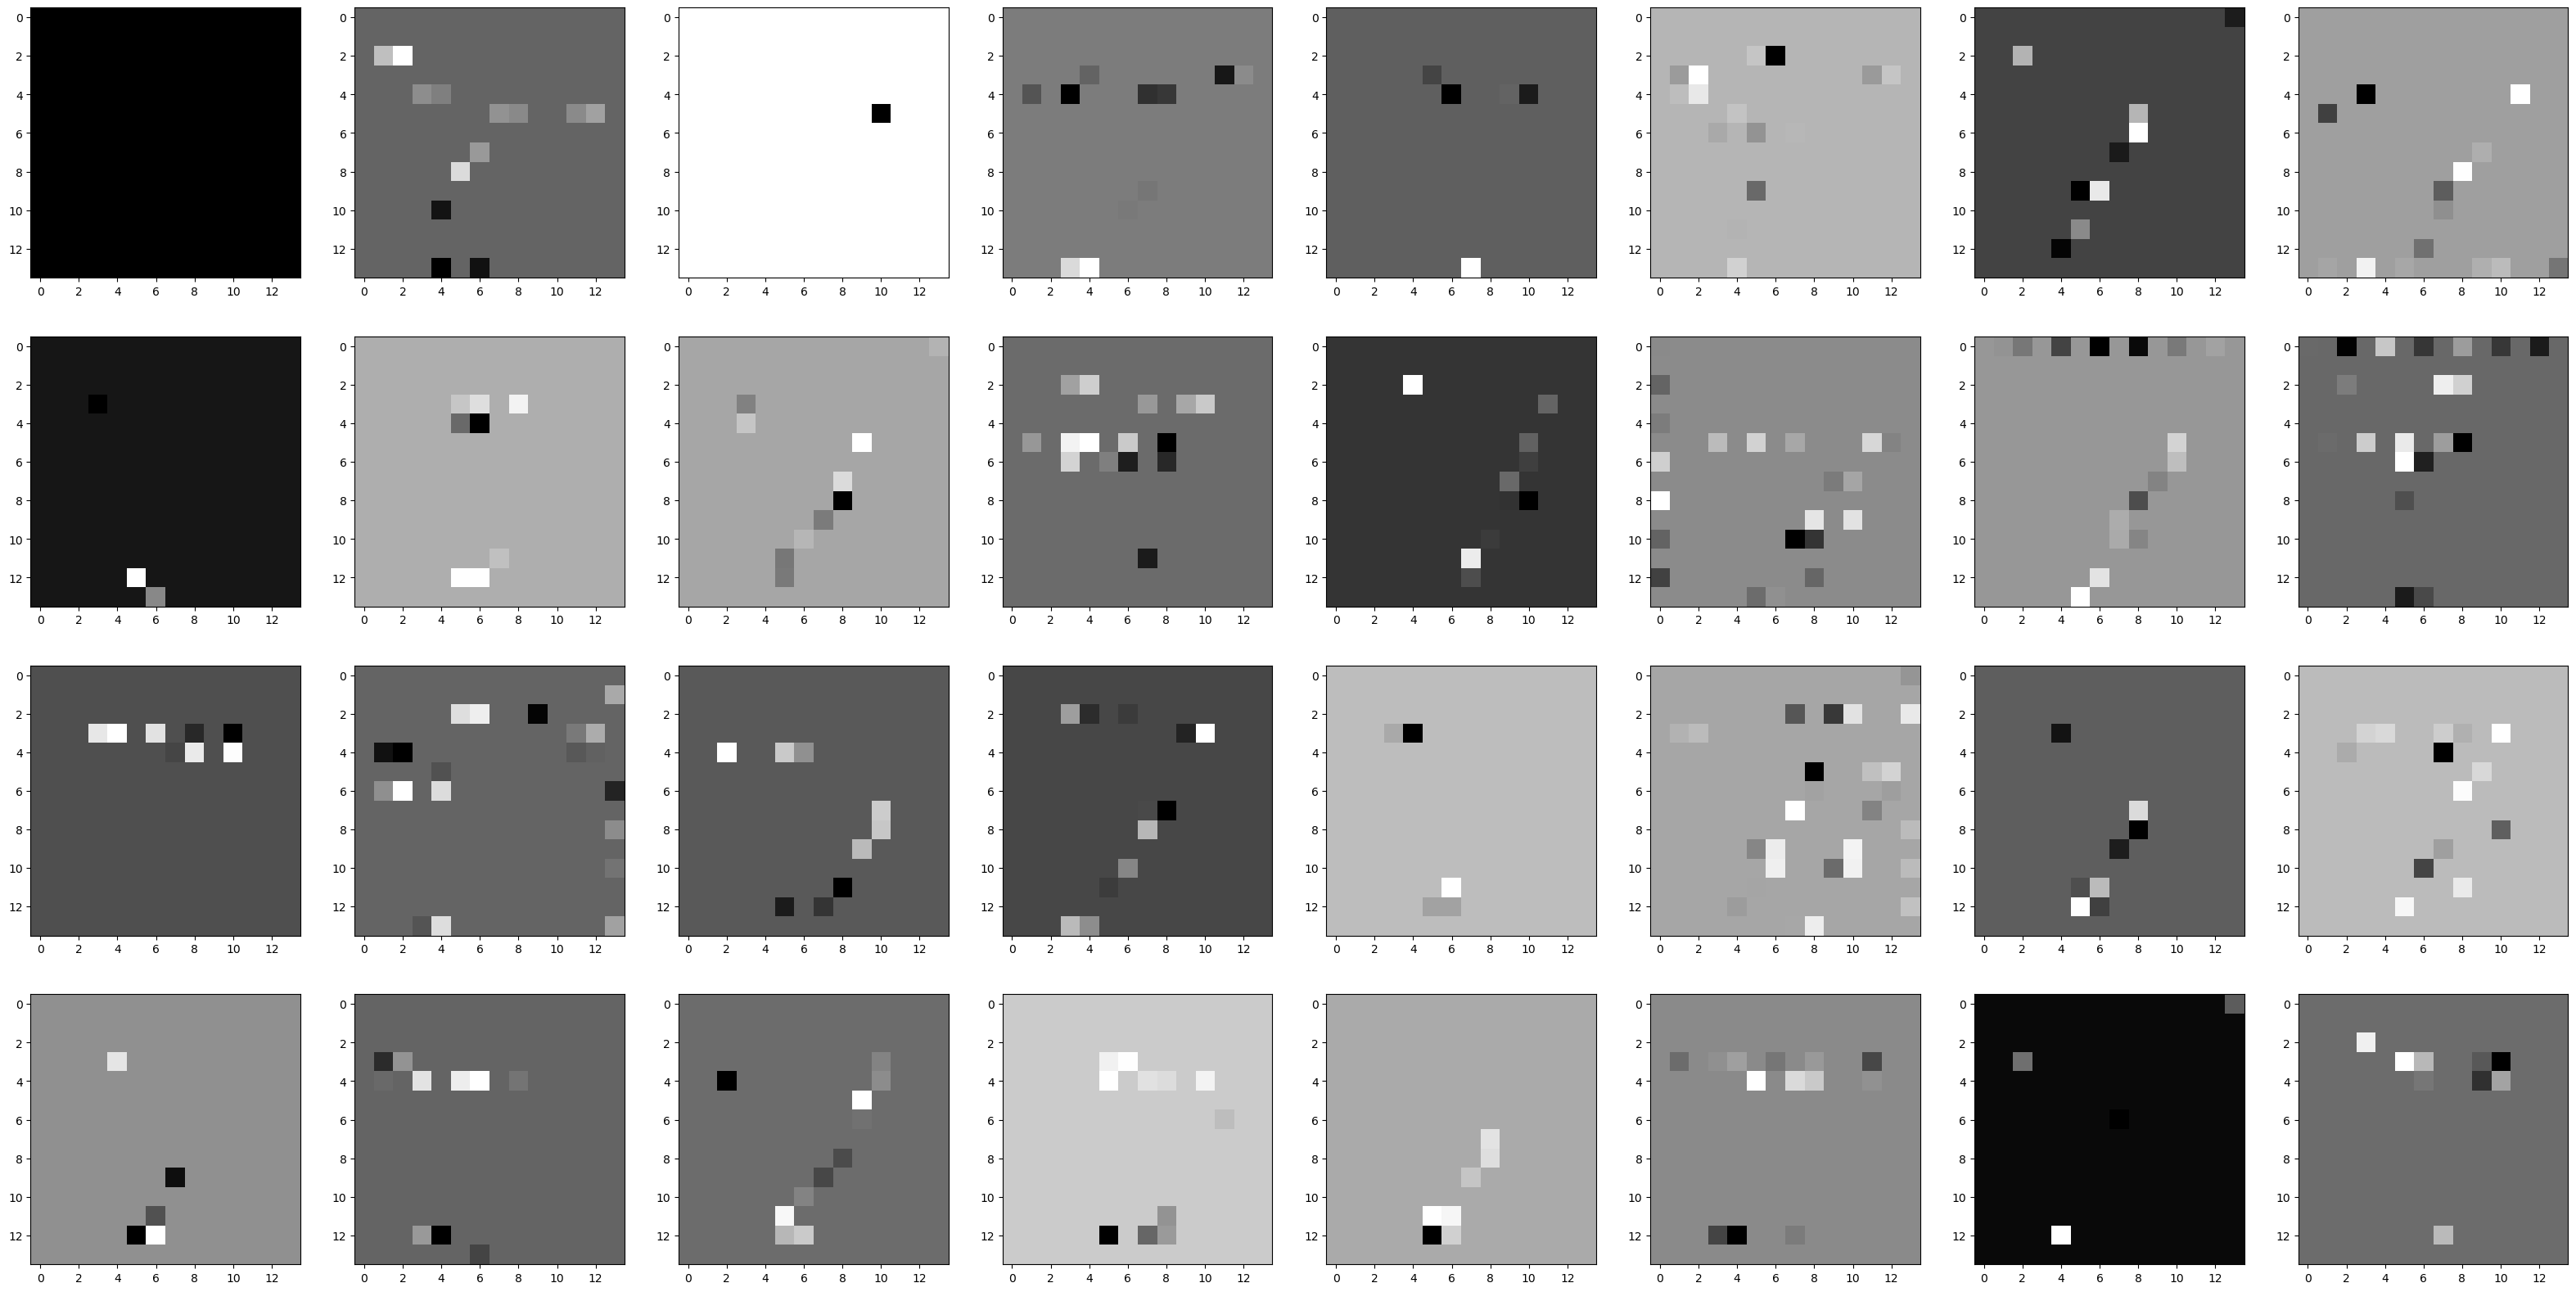

In [20]:

grad=save.layer_grad[0].squeeze(0).numpy()
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(40,20))
for i,im in enumerate(grad):
    ax1=fig.add_subplot(4,8,i+1)
    ax1.imshow(im,'gray')

なんかそれっぽいものが出てきた。次はこの情報を使って実際にgradCAMとかを計算したい